_Following the tutorial from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy on the Kaggle titanic problem https://www.kaggle.com/c/titanic. I am using this a tutorial as a refresher of the practical aspect of machine learning and data science to unsure that I do not lose my skills from my masters degree. It will aslo allow me to see a project tackled from another perspective and hopefully allow me to learn something new_

# 1. Defining the problem
It is a binary supervised learning task that looks to predict if an individual will survive the sinking of HMS Titanic. 

__Project summary:__ The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.vOne of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

# 2. Gathering the data
The date for this problem is not include within this repository but can be found here: https://www.kaggle.com/c/titanic/data instead

# 3. Prepare the data
The data is already in .csv format and is deliberately in an easy to use format so the only requirement here is data cleaning. 

We will start by import the neccassary libraries

In [51]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn

import random 
import time

import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [52]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [53]:
data_raw = pd.read_csv("./data/train.csv")
data_val = pd.read_csv("./data/test.csv") # not sure that the test data should be used for validation but this is what the tutorial says to do
data1 = data_raw.copy(deep=True) # copy of the training data used for playing with
# Learning: having two copies of the data can be very useful
data_cleaner = [data1, data_val]

print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## Data inspection
- Survived: our target (dependant) variable. 1 for survived and 0 for dead
- Independant variables:
    - PassengerID & Ticket: assumed to random unique identifiers and can be ignored from the dataset when training / predicting
    - Pclass: ordinal datatype for the ticket class (basically social standing of passenger), 1 is upper, 2 is middle and 3 is lower class
    - Name: nominal datatype that we could use for feature engineering to extract title (Mr/Mrs) or family size from surname
    - Sex and Embarked: nominal datatypes
    - Age and Fare: continuous quantitative datatypes
    - SibSp: representes number of related siblings/spouse aboard and Parch represntes number of related parents/children onbpard. We can combine these to create family size
    - Cabin: nominal datatype that can be used in feature engineering to approximate the position on ship when incident occurred but there are many null values so doesn't really add value and can therefore be dropped

## The 4 C's of Cleaning
- Correcting: Does not appear to be any aberrant or non-acceptable data inputs so we can leave correcting for now until later inspection requires it
- Completing: There are missing values in age, cabin, and embarked fields. Here we will input median value for age, cabin attribute is dropped and embark will be imputed with mode. These decisions are basic and more complex approaches could be investigated at a later date 
- Creating: the only feature we can really create is title from the name of the entry
- Converting: There are no date or currency formats to worry about but we must handle the datatype attributes. The object datatypes can be converted to categorical variables

In [54]:
# Learning: how to easy check for null values
print(f"Train columns with null values:\n{data1.isnull().sum()}")
print('-'*20)

print(f'Test/Validation columns with null values:\n {data_val.isnull().sum()}')
print("-"*20)

data_raw.describe(include='all')

Train columns with null values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Now begining cleaning

In [55]:
# Learning: how to easily handle null values and drop columns

for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

data1.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)

print(data1.isnull().sum())
print('-'*20)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [56]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## Feature Engineering

In [59]:
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 # not sure if the '+1' actually really does much here
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # if the family size of a passenger is equally to 1 they are alone (1) otherwise they are not (0)

    dataset['Title'] = dataset['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    
    # Learning: bin splitting with pandas
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

In [62]:
stat_min = 10 # the minimun number of occurnaces needed for title name to persist
title_names = (data1['Title'].value_counts() < stat_min)

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print('-'*20)

data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pandas.core.frame.Data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
576,1,2,"Garside, Miss. Ethel",female,34.0,0,0,13.0000,S,1,1,Miss,"(7.91, 14.454]","(32.0, 48.0]"
779,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,211.3375,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
485,0,3,"Lefebre, Miss. Jeannie",female,28.0,3,1,25.4667,S,5,0,Miss,"(14.454, 31.0]","(16.0, 32.0]"
237,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.0,0,2,26.2500,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
622,1,3,"Nakid, Mr. Sahid",male,20.0,1,1,15.7417,C,3,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
429,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
213,0,2,"Givard, Mr. Hans Kristensen",male,30.0,0,0,13.0000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,3,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"
846,0,3,"Sage, Mr. Douglas Bullen",male,28.0,8,2,69.5500,S,11,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"
671,0,1,"Davidson, Mr. Thornton",male,31.0,1,0,52.0000,S,2,0,Mr,"(31.0, 512.329]","(16.0, 32.0]"


## Encoding data
Converting the raw data into a type of data that can be used by the models

In [63]:
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

Selecting the x and y attributes that will be used in the models for independent and dependent 

In [66]:
Target = ['Survived']
# The original features that we are going to keep
data1_x = ['Sex', 'Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
# features that have been altered / coded for model input
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print(f'Original X Y: {data1_xy} \n')

# input features that are in bins to remove continuos variables
data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')


data1_dummy.head()

Original X Y: ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


## Double checking the cleaned data
To ensure no null values persit

In [71]:
print(f'Non-null values in each column for training \n{data1.isnull().sum()}')
print('-'*20)
print(data1.info())

print(f'Non-null values in each column for testing \n{data_val.isnull().sum()}')
print('-'*20)
print(data_val.info())

Non-null values in each column for training 
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   

# Splitting the data
Into training and testing data - we use a 75/25 split for validation

In [72]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print(f"Data1 Shape: {data1.shape}")
print(f"Train1 Shape: {train1_x.shape}")
print(f"Test1 Shape: {test1_x.shape}")

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


# Data Analysis
We will have a look into the data to see what we can see from it
Start with discrete variables percentage split of labels

In [76]:
for x in data1_x:
    if data1[x].dtype != 'float64':
        print(f'Survival Correlation by: {x}')
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*20)

print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
--------------------
Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
--------------------
Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
--------------------
Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
--------------------
Survival Correlation by: FamilySize
  

- We can see that if you are female you are arounf 3x more likely to survive
- The better the class of your ticket the more likely you are too survive
- The younger your Title the better the chance of survival
- The less siblings you have the better the chances
- Parch has little correlation
- Familys of size 4 is optimal looks like a bell curve
- Also those alone had worse chance of surviving

Now look into graphics 

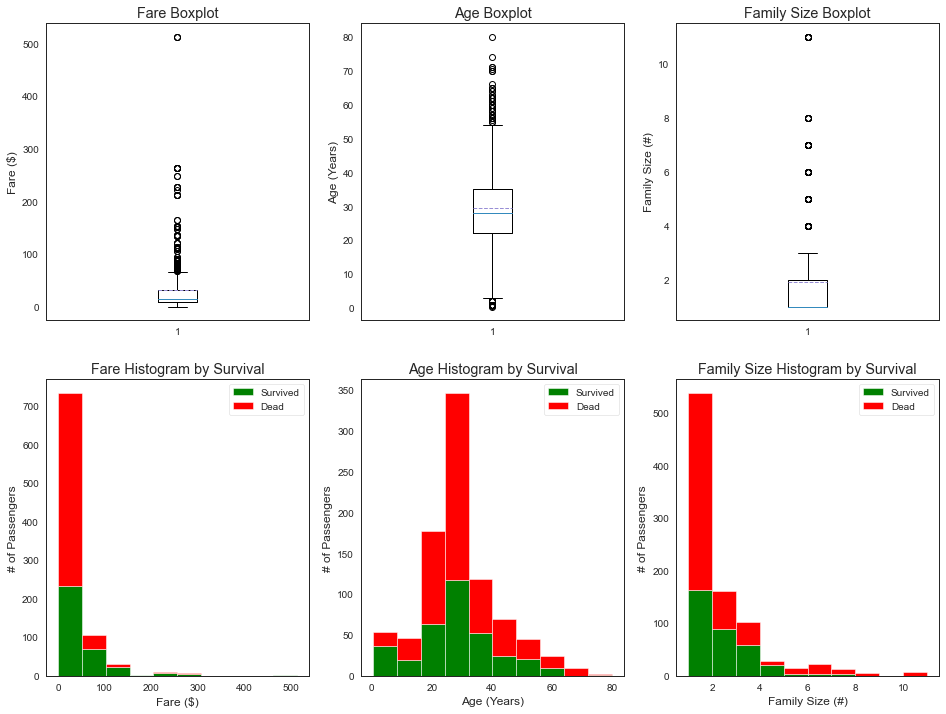

In [77]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

These graphics show the spread of fare, age, and family size withing the bins. This doesn't really tell us much 
We can now use Seaborn to look at ho different catergories effect chances of surviving

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

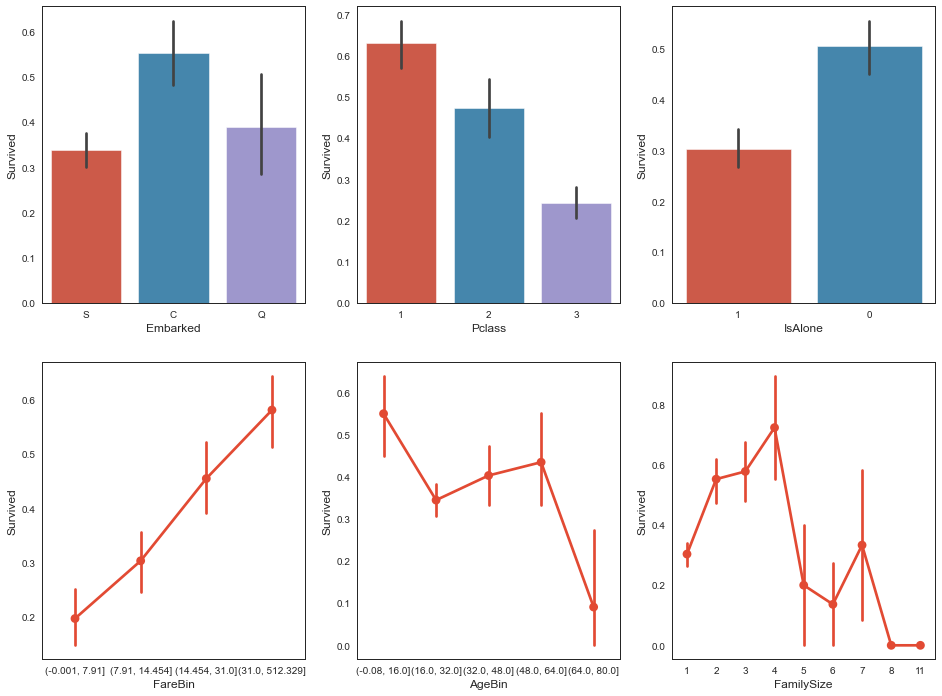

In [78]:
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

These figures do tell us a lot more. From these graphics if you want to survive you should be:
- Embarked: C
- Be in first class
- Do not be alone (have family onboard)
- Be richer (have a more expensive ticket)
- Be younger (pretty much but not exactly)
- Have a family size of 4